In [183]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx

from data_conversions import selectData, transformData
from data_conversions import floatifyData, boolifyData, quantizeData
from sampling import mkSamps, toHisto, toProbV
from sampling import createSparseBinner as createBinner
from metropolis import mutualInfo, genMetropolisSamples
from agent_based_model import createWeightedSamplesGenerator, select_subset, createWeightSer, lnLik, mutate


In [184]:
    fullDF = pd.read_csv('/home/welling/git/synecoace/data/nsch_2016_topical.csv',
                         encoding='utf-8')
    print(fullDF.columns)
    fipsD = {'SC':45, 'NC':37, 'TN':47, 'GA':13,
             'AL':1, 'VA':51, 'LA':22, 'AR':5}
    subDF, acesL, boolColL, scalarColL = transformData(selectData(fullDF.reset_index(),
                                                                  fipsL=fipsD.values(),
                                                                  includeFips=True))
    # columns we think will be fixed throughout life
#     fixedL = ['BIRTHWT_VL', 'BIRTHWT_L', 'PREMATURE',
#               'HHLANGUAGE_ENGLISH', 'HHLANGUAGE_SPANISH',
#               'SC_FEMALE', 'SC_RACE_NATIVE', 'SC_RACE_ASIAN',
#               'SC_RACE_ISLANDS', 'SC_RACE_OTHER', 'SC_RACE_MIXED',
#               'SC_RACE_HISPANIC', 'MOMAGE_LT_20', 'MOMAGE_GT_39',
#               'BIRTHORDER_2', 'BIRTHORDER_3',
#               'BIRTHORDER_4']
    fixedL = ['BIRTHWT_VL', 'PREMATURE',
              'HHLANGUAGE_ENGLISH',
              'SC_FEMALE', 'SC_RACE_NATIVE', 'SC_RACE_ASIAN',
              'SC_RACE_ISLANDS', 'SC_RACE_OTHER', 'SC_RACE_MIXED',
              'SC_RACE_HISPANIC', 'MOMAGE_LT_20', 'MOMAGE_GT_39']
    dropL = ['DRUGSALCOHOL', 'MENTALILL', 'PARENTDIED', 'PARENTDIVORCED',
             'PARENTJAIL', 'RACISM', 'SEEPUNCH', 'VIOLENCE',
             'SC_RACE_WHITE', 'TOTCSHCN', 'TOTACES']
    subDF = subDF.drop(columns=dropL)
    for col in dropL:
        if col in acesL: acesL.remove(col)
        if col in boolColL: boolColL.remove(col)
        if col in scalarColL: scalarColL.remove(col)

    #print(scalarColL)
    ageL = subDF['AGE'].unique()
    print('ages: ', ageL)
    ageMin = int(min(ageL))
    ageMax = int(max(ageL))
    scalarColL.remove('AGE')
    print('scalar columns: ', scalarColL)
    ageDFD = {}
    range_d = None
    for age in range(ageMin, ageMax+1):
        ageDF = subDF[subDF.AGE==age].drop(columns=['AGE', 'FIPSST'])
        ageDFD[age], _, _, _, dct = quantizeData(ageDF, acesL, boolColL, scalarColL)
        if range_d is None:
            range_d = dct
        else:
            assert dct == range_d, 'Quantized ranges do not match?'

    weightedSampGen = createWeightedSamplesGenerator(1000)

    df = subDF[subDF.AGE==ageMin].drop(columns='AGE')
    df = df[df.FIPSST == fipsD['SC']].drop(columns=['FIPSST'])
    df, _, _, _, dct = quantizeData(df, acesL, boolColL, scalarColL)
    assert dct == range_d, 'Quantized ranges do not match?'
    scSampGen = createWeightedSamplesGenerator(1)
    prototype = scSampGen(ageDFD[ageMin])
    print('prototype columns: ', prototype.columns)


Index(['FIPSST', 'HHID', 'FORMTYPE', 'TOTKIDS_R', 'HHLANGUAGE', 'SC_AGE_YEARS',
       'SC_SEX', 'K2Q35A_1_YEARS', 'MOMAGE', 'K6Q41R_STILL',
       ...
       'BIRTHWT', 'CBSAFP_YN', 'FWC', 'CURRINS', 'INSTYPE', 'HOUSE_GEN',
       'HHSIZE_I', 'HHSIZE_IF', 'FPL_IF', 'INSGAP'],
      dtype='object', length=422)
ages:  [10. 13.  9.  6. 12. 17.  7.  8. 16. 15. 14. 11.]
scalar columns:  ['BIRTHORDER', 'FPL', 'MOMAGE', 'TOTKIDS']
prototype columns:  Index(['BIRTHWT_L', 'BIRTHWT_VL', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT',
       'HHLANGUAGE_ENGLISH', 'HHLANGUAGE_SPANISH', 'PREMATURE', 'SC_CSHCN',
       'SC_FEMALE', 'SC_RACE_ASIAN', 'SC_RACE_BLACK', 'SC_RACE_HISPANIC',
       'SC_RACE_ISLANDS', 'SC_RACE_MIXED', 'SC_RACE_NATIVE', 'SC_RACE_OTHER',
       'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL',
       'MOMAGE_LT_20', 'MOMAGE_GT_39', 'TOTKIDS_minusone'],
      dtype='object')


In [185]:
fixed_l = fixedL
aces_l = acesL
samp_gen = weightedSampGen
all_samples = ageDFD[ageMin]
new_all_samples = ageDFD[ageMin + 1]
fixed_d = {elt: prototype.iloc[0][elt] for elt in fixed_l}
self_fixed_keys = fixed_d 
self_samp_gen = samp_gen
self_age = ageMin # whatever is in the prototype
self_range_d = range_d
self_inner_cohort = samp_gen(prototype)
self_outer_cohort = samp_gen(select_subset(all_samples, self_fixed_keys))
advancing_l = []
for elt in aces_l:
    if prototype.iloc[0][elt]:
        fixed_d[elt] = True
    else:
        advancing_l.append(elt)
self_advancing_l = advancing_l
open_l = [k for k in self_outer_cohort.columns]
for elt in list(fixed_d) + advancing_l:
    open_l.remove(elt)
self_open_l = open_l
print('outer_cohort unique entries: ', self_outer_cohort.index.unique())

all_col_l = self_open_l + self_advancing_l
which_bin = createBinner(all_col_l, range_d=self_range_d)
wt_ser = createWeightSer(all_col_l, range_d=self_range_d)
samples_subset = select_subset(new_all_samples, self_fixed_keys)
new_outer_cohort = self_samp_gen(samples_subset)


begin select_subset: 223 records, 223 unique
BIRTHWT_VL == 0: 220 entries, 220 unique
PREMATURE == 0: 188 entries, 188 unique
HHLANGUAGE_ENGLISH == 1: 175 entries, 175 unique
SC_FEMALE == 1: 98 entries, 98 unique
SC_RACE_NATIVE == 0: 98 entries, 98 unique
SC_RACE_ASIAN == 0: 95 entries, 95 unique
SC_RACE_ISLANDS == 0: 95 entries, 95 unique
SC_RACE_OTHER == 0: 93 entries, 93 unique
SC_RACE_MIXED == 0: 87 entries, 87 unique
SC_RACE_HISPANIC == 0: 78 entries, 78 unique
MOMAGE_LT_20 == 0: 76 entries, 76 unique
MOMAGE_GT_39 == 0: 74 entries, 74 unique
outer_cohort unique entries:  Int64Index([19680, 45965, 28964, 30041, 49357, 11579, 43386, 13752, 41583,
            35417,  7917, 40591, 25825,  8190, 42549, 27565, 42927, 16861,
            41533, 14742,  5346, 39276, 35082, 17930,  5237, 49868,  4802,
            24417, 46072,  6763, 11997, 10342,  8352,  2771,  5207, 10913,
             8171, 17232,  8720, 34481, 36872, 39795, 41257, 39891,  1080,
            45492, 41183, 48252, 49522,  5

In [186]:
#print(self_outer_cohort.iloc[17337])
self_outer_cohort.loc[17337]


KeyError: 17337

In [187]:
samples_subset.index

Int64Index([  342,   406,   544,  1142,  1774,  2240,  3525,  3626,  5582,
             5683,  5863,  6180,  7073,  8215,  8882,  8997,  9136, 10648,
            11664, 12640, 12869, 12870, 12908, 13821, 14052, 14231, 14284,
            14561, 15902, 16131, 17141, 17302, 17348, 18599, 19412, 21044,
            22268, 23160, 23184, 23200, 24209, 25224, 25712, 26042, 26092,
            27210, 28077, 28583, 28889, 29216, 29299, 29648, 29745, 30666,
            30787, 31381, 31409, 31453, 32091, 33242, 33482, 33631, 34354,
            35126, 35147, 36763, 37191, 37464, 39096, 39262, 39702, 39874,
            40088, 40572, 41404, 43494, 43518, 44837, 46719, 47162, 47810,
            47893, 48066, 48477, 50034],
           dtype='int64')

In [188]:
samples_subset.columns


Index(['FWC', 'index', 'BIRTHWT_L', 'BIRTHWT_VL', 'CLUBS', 'DENTALCARE',
       'DOCTORVISIT', 'HHLANGUAGE_ENGLISH', 'HHLANGUAGE_SPANISH', 'PREMATURE',
       'SC_CSHCN', 'SC_FEMALE', 'SC_RACE_ASIAN', 'SC_RACE_BLACK',
       'SC_RACE_HISPANIC', 'SC_RACE_ISLANDS', 'SC_RACE_MIXED',
       'SC_RACE_NATIVE', 'SC_RACE_OTHER', 'SPORTSTEAMS', 'VISIONCARE',
       'BIRTHORDER_minusone', 'FPL', 'MOMAGE_LT_20', 'MOMAGE_GT_39',
       'TOTKIDS_minusone'],
      dtype='object')

In [189]:
new_outer_cohort.index.unique()

Int64Index([ 1774, 21044, 24209, 43494,  3525, 29216,  9136, 12640, 39096,
            14561, 36763, 44837, 29745,  6180, 12908, 34354, 47893, 39874,
              406, 28077,  7073, 48066, 17348, 14052,  5863, 39262, 50034,
            37191, 14284, 23200,  8997, 19412, 33631, 26092, 26042, 16131,
            14231, 28889, 29648, 11664, 15902,   342, 46719, 43518, 41404,
            28583, 35126,  3626, 40572, 25712, 40088, 33482, 48477, 23160,
            47810, 35147,  5683, 27210, 10648, 32091, 18599, 29299, 23184,
            12870,  8215, 30787, 37464, 39702, 30666, 12869, 17302, 31381,
             5582, 13821, 22268,  2240, 31409, 47162, 17141,  1142,   544,
            25224, 31453],
           dtype='int64')

In [190]:
new_outer_cohort.drop_duplicates().shape


(72, 24)

In [191]:
df = new_outer_cohort.drop_duplicates()
nrows = len(df)
mtx = np.zeros((nrows, nrows))

In [192]:
index_l = df.index.tolist()[:]
offset_d = {offset : idx for offset, idx in enumerate(index_l)}

In [193]:
for off0 in range(nrows):
    row0 = df.loc[offset_d[off0]]
    v0 = row0.values
    for off1 in range(nrows):
        row1 = df.loc[offset_d[off1]]
        v1 = row1.values
        mtx[off0, off1] = sum(np.abs(v1 - v0))
print(mtx)


[[ 0. 10.  4. ...  4.  3.  6.]
 [10.  0.  8. ... 10. 11. 10.]
 [ 4.  8.  0. ...  4.  3.  6.]
 ...
 [ 4. 10.  4. ...  0.  1.  8.]
 [ 3. 11.  3. ...  1.  0.  7.]
 [ 6. 10.  6. ...  8.  7.  0.]]


In [194]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [195]:
sp_mtx = minimum_spanning_tree(mtx)
print(sp_mtx)

  (0, 3)	1.0
  (1, 22)	3.0
  (2, 45)	1.0
  (3, 30)	1.0
  (3, 41)	2.0
  (3, 64)	1.0
  (4, 25)	1.0
  (5, 39)	2.0
  (5, 64)	2.0
  (7, 18)	3.0
  (8, 5)	2.0
  (10, 1)	3.0
  (12, 57)	1.0
  (13, 6)	1.0
  (13, 16)	1.0
  (14, 47)	2.0
  (15, 10)	2.0
  (16, 3)	1.0
  (16, 47)	1.0
  (18, 56)	2.0
  (19, 4)	2.0
  (19, 49)	2.0
  (20, 63)	1.0
  (21, 46)	2.0
  (23, 14)	3.0
  :	:
  (45, 36)	1.0
  (46, 33)	1.0
  (47, 34)	1.0
  (48, 71)	2.0
  (49, 15)	3.0
  (50, 15)	2.0
  (51, 67)	2.0
  (51, 70)	2.0
  (54, 35)	2.0
  (56, 24)	2.0
  (57, 59)	1.0
  (58, 18)	1.0
  (59, 68)	2.0
  (60, 28)	2.0
  (62, 37)	2.0
  (62, 48)	2.0
  (62, 58)	2.0
  (64, 45)	1.0
  (64, 65)	2.0
  (66, 27)	3.0
  (66, 71)	1.0
  (67, 66)	2.0
  (69, 42)	1.0
  (69, 47)	1.0
  (70, 69)	1.0


In [196]:
sp_mtx.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [206]:
def gen_mst(df):
    idx_df = df.reset_index().drop_duplicates()
    nrows = len(idx_df)
    mtx = np.zeros((nrows, nrows))
    offset_d = {offset : row['index'] for offset, (idx, row) in enumerate(idx_df[['index']].iterrows())}
    idx_d = {v : k for k, v in offset_d.items()}
    idx_df.index = idx_df['index']
    unique_df = idx_df.drop(columns=['index'])
    G = nx.Graph()
    for off0 in range(nrows):
        row0 = unique_df.loc[offset_d[off0]]
        v0 = row0.values
        for off1 in range(nrows):
            row1 = unique_df.loc[offset_d[off1]]
            v1 = row1.values
            wt = sum(np.abs(v1 - v0))
            if off0 != off1:
                wt += 1
            mtx[off0, off1] = wt
            G.add_edge(off0, off1, weight=wt)
    sp_mtx = minimum_spanning_tree(mtx)
    MT = nx.minimum_spanning_tree(G)
    return sp_mtx.todense(), offset_d, idx_d, MT

In [207]:
sm, offset_d, idx_d, MT = gen_mst(new_outer_cohort)
#idx_d
G

In [200]:
for i in range(mtx.shape[0]):
    for j in range(mtx.shape[1]):
        if mtx[i,j] == 0 and i != j:
            print(i,j)

In [210]:
for i in range(sm.shape[0]):
    for j in range(sm.shape[1]):
        if sm[i,j] != 0 and sm[j,i] != 0:
            print(i,j)

In [211]:
ssm = sm + sm.transpose()

In [216]:
print(ssm)
for row_off in range(ssm.shape[0]):
    row = ssm[row_off, :]
    print(row)
    print(row.nonzero()[1])
    candidates = row.nonzero()[1]
    offset = np.random.choice(candidates)
    print(offset)
    print(offset_d[offset])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[41]
41
342
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0.
  4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[16 24]
24
5863
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[52]
52
48477
[[0. 0. 0. 0. 0. 0. 0. 0.

65
30787
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[32]
32
33631
[[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]]
[ 2 42 75]
75
2240
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[30 35]
35
16131
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.

In [236]:
def mutate_fun(idx, ssm, idx_d, offset_d):
    row_off = idx_d[idx]
    row = ssm[row_off, :]
    candidates = row.nonzero()[1]
    offset = np.random.choice(candidates)
    return offset_d[offset]
mutate_vec = np.vectorize(mutate_fun, excluded=['ssm', 'idx_d', 'offset_d'])

In [238]:
idxV = np.random.choice(new_outer_cohort.index.values, 20)
for _ in range(10):
    print(idxV)
    print('--------')
    idxV = mutate_vec(idxV, ssm=ssm, idx_d=idx_d, offset_d=offset_d)

[ 3626 12640 29745 29648 43518  5863   342 35147 43518 26092   406 14284
   406 33631  5582 37464  3626 35126 14284 36763]
--------
[29745 28077  3626 47810 14052 21044  1774 30666 14052 31381 17348 43518
 17348   342 10648 47162 29745 29216 43518 47893]
--------
[39702 12640 29745 29648 43518 47893   342 35147 43518 26092   406  8997
 22268 26042 17141 23200 27210  2240 14052 21044]
--------
[12869 28077  3626 47810  8997 27210 40572 30666 13821 41404 17348 17302
 17348   342 47162 47162 29745 18599 43518 47893]
--------
[39702 12640 29745 34354 17302 47893   342 13821 43518 25712 19412  8997
   406  1774 23200 17141  3626 15902 14052 36763]
--------
[29745 28077 39702 39262  8997 36763 33631 30666 14052 44837 17348 17302
 17348   342 47162 10648 29745 18599 43518 47893]
--------
[ 3626 30666 12869 34354 23160 47893 33482 35147 43518 25712 19412  8997
 19412 15902 31453 17141 39702  2240 14284 21044]
--------
[29745 28077 39702 39262  8997 21044 33631 30666 14284   544 17348 17302
 17

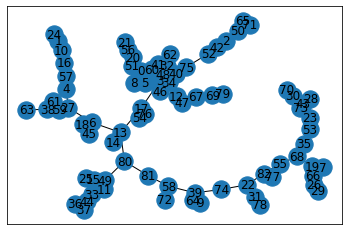

In [208]:
#N=30
#G=nx.grid_2d_graph(N,N)
#pos = dict( (n, n) for n in G.nodes() )
#labels = dict( ((i, j), i + (N-1-j) * N ) for i, j in G.nodes() )
#nx.relabel_nodes(G,labels,False)
#inds=labels.keys()
#vals=labels.values()
#inds.sort()
#vals.sort()
#pos2=dict(zip(vals,inds))
#nx.draw_networkx(G, pos=pos2, with_labels=False, node_size = 15)
plt.figure()
nx.draw_networkx(MT)
plt.show()

In [153]:
row_idx_v = new_outer_cohort.index.tolist()
row_idx_v


[42456,
 10908,
 40977,
 48041,
 11600,
 10908,
 27779,
 20452,
 43068,
 27377,
 2233,
 33224,
 4758,
 29515,
 10680,
 14057,
 2663,
 30736,
 29515,
 29515,
 5990,
 30736,
 42445,
 11600,
 45114,
 16141,
 45114,
 6866,
 10908,
 39054,
 39300,
 30736,
 26422,
 10680,
 4231,
 40977,
 49061,
 29515,
 50036,
 45114,
 29515,
 39300,
 2663,
 40977,
 11600,
 10680,
 37338,
 14057,
 34607,
 4758,
 3890,
 3852,
 40977,
 26422,
 11600,
 48041,
 26422,
 2663,
 44105,
 17999,
 42445,
 17620,
 19318,
 40977,
 49061,
 39054,
 14057,
 17999,
 10908,
 20452,
 50036,
 48041,
 10908,
 22940,
 2890,
 31700,
 16141,
 22439,
 14057,
 42445,
 2663,
 1627,
 10908,
 50036,
 11022,
 10908,
 40977,
 29515,
 27377,
 50036,
 24736,
 20452,
 20452,
 17999,
 33224,
 16141,
 4758,
 6866,
 31700,
 4231,
 29515,
 44105,
 40243,
 29515,
 2663,
 37338,
 16141,
 10908,
 37338,
 49061,
 10680,
 6866,
 6866,
 6866,
 45338,
 10908,
 20452,
 29515,
 3890,
 30736,
 10908,
 1627,
 49061,
 10908,
 10908,
 48041,
 20452,
 29515,

In [154]:
row_off_v = np.vectorize(lambda x: idx_d[x])(row_idx_v)
row_off_v

array([ 0,  1,  2,  3,  4,  1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 12, 12, 17, 16, 18,  4, 19, 20, 19, 21,  1, 22, 23, 16, 24, 13,
       25,  2, 26, 12, 27, 19, 12, 23, 15,  2,  4, 13, 28, 14, 29, 11, 30,
       31,  2, 24,  4,  3, 24, 15, 32, 33, 18, 34, 35,  2, 26, 22, 14, 33,
        1,  6, 27,  3,  1, 36, 37, 38, 20, 39, 14, 18, 15, 40,  1, 27, 41,
        1,  2, 12,  8, 27, 42,  6,  6, 33, 10, 20, 11, 21, 38, 25, 12, 32,
       43, 12, 15, 28, 20,  1, 28, 26, 13, 21, 21, 21, 44,  1,  6, 12, 30,
       16,  1, 40, 26,  1,  1,  3,  6, 12, 13, 13,  1,  2, 13,  2, 13,  1,
        1,  1, 30, 42,  3, 28, 43,  7, 37, 13, 19,  6, 31, 16, 18, 12,  2,
       45, 28, 21, 46,  1, 46, 28, 33, 22, 33, 23, 29, 13, 33, 22, 13,  3,
       12, 38, 22,  1,  5, 33, 30, 33,  6, 47, 48, 48, 22,  8, 28, 41,  3,
       49, 33, 22, 13, 16, 30,  2, 33, 12, 20, 46, 33, 50,  1, 39,  2,  5,
        3, 51, 50, 20, 21, 15, 32, 52,  6, 34, 43, 29, 17, 20, 13, 12, 13,
       23, 53,  1, 34,  1

In [156]:
for row in row_off_v:
    print(row)
    candidates = sm[row,:]
    print(candidates.nonzero())


0
(array([], dtype=int64), array([], dtype=int64))
1
(array([], dtype=int64), array([], dtype=int64))
2
(array([], dtype=int64), array([], dtype=int64))
3
(array([0, 0]), array([20, 30]))
4
(array([0]), array([44]))
1
(array([], dtype=int64), array([], dtype=int64))
5
(array([0, 0]), array([ 9, 41]))
6
(array([], dtype=int64), array([], dtype=int64))
7
(array([], dtype=int64), array([], dtype=int64))
8
(array([0]), array([48]))
9
(array([], dtype=int64), array([], dtype=int64))
10
(array([], dtype=int64), array([], dtype=int64))
11
(array([0]), array([43]))
12
(array([0]), array([20]))
13
(array([0, 0]), array([16, 58]))
14
(array([0, 0]), array([35, 64]))
15
(array([], dtype=int64), array([], dtype=int64))
16
(array([], dtype=int64), array([], dtype=int64))
12
(array([0]), array([20]))
12
(array([0]), array([20]))
17
(array([0]), array([64]))
16
(array([], dtype=int64), array([], dtype=int64))
18
(array([0]), array([63]))
4
(array([0]), array([44]))
19
(array([0]), array([7]))
20
(arr

(array([0]), array([64]))
20
(array([0, 0]), array([22, 34]))
13
(array([0, 0]), array([16, 58]))
12
(array([0]), array([20]))
13
(array([0, 0]), array([16, 58]))
23
(array([0, 0, 0, 0]), array([14, 28, 38, 42]))
53
(array([0]), array([37]))
1
(array([], dtype=int64), array([], dtype=int64))
34
(array([0]), array([57]))
1
(array([], dtype=int64), array([], dtype=int64))
12
(array([0]), array([20]))
16
(array([], dtype=int64), array([], dtype=int64))
27
(array([0]), array([47]))
2
(array([], dtype=int64), array([], dtype=int64))
42
(array([], dtype=int64), array([], dtype=int64))
54
(array([0]), array([7]))
12
(array([0]), array([20]))
32
(array([0, 0]), array([62, 64]))
28
(array([0]), array([2]))
15
(array([], dtype=int64), array([], dtype=int64))
29
(array([], dtype=int64), array([], dtype=int64))
15
(array([], dtype=int64), array([], dtype=int64))
15
(array([], dtype=int64), array([], dtype=int64))
33
(array([], dtype=int64), array([], dtype=int64))
26
(array([0]), array([56]))
28
(

(array([0, 0]), array([35, 64]))
1
(array([], dtype=int64), array([], dtype=int64))
33
(array([], dtype=int64), array([], dtype=int64))
1
(array([], dtype=int64), array([], dtype=int64))
3
(array([0, 0]), array([20, 30]))
50
(array([0]), array([34]))
27
(array([0]), array([47]))
46
(array([0, 0, 0]), array([ 0, 10, 28]))
59
(array([], dtype=int64), array([], dtype=int64))
7
(array([], dtype=int64), array([], dtype=int64))
17
(array([0]), array([64]))
39
(array([0, 0]), array([15, 47]))
28
(array([0]), array([2]))
3
(array([0, 0]), array([20, 30]))
49
(array([0]), array([64]))
2
(array([], dtype=int64), array([], dtype=int64))
23
(array([0, 0, 0, 0]), array([14, 28, 38, 42]))
28
(array([0]), array([2]))
52
(array([0, 0]), array([ 7, 42]))
46
(array([0, 0, 0]), array([ 0, 10, 28]))
1
(array([], dtype=int64), array([], dtype=int64))
1
(array([], dtype=int64), array([], dtype=int64))
55
(array([], dtype=int64), array([], dtype=int64))
38
(array([], dtype=int64), array([], dtype=int64))
33


(array([0]), array([43]))
12
(array([0]), array([20]))
41
(array([0, 0, 0]), array([ 6, 27, 31]))
28
(array([0]), array([2]))
29
(array([], dtype=int64), array([], dtype=int64))
1
(array([], dtype=int64), array([], dtype=int64))
4
(array([0]), array([44]))
37
(array([0, 0]), array([55, 64]))
28
(array([0]), array([2]))
15
(array([], dtype=int64), array([], dtype=int64))
2
(array([], dtype=int64), array([], dtype=int64))
22
(array([0]), array([1]))
21
(array([0, 0]), array([33, 50]))
34
(array([0]), array([57]))
13
(array([0, 0]), array([16, 58]))
41
(array([0, 0, 0]), array([ 6, 27, 31]))
16
(array([], dtype=int64), array([], dtype=int64))
37
(array([0, 0]), array([55, 64]))
33
(array([], dtype=int64), array([], dtype=int64))
12
(array([0]), array([20]))
47
(array([], dtype=int64), array([], dtype=int64))
15
(array([], dtype=int64), array([], dtype=int64))
13
(array([0, 0]), array([16, 58]))
37
(array([0, 0]), array([55, 64]))
47
(array([], dtype=int64), array([], dtype=int64))
12
(arr